## Image Patches with Image网

We'd like to make use of the [Image网 dataset](https://github.com/fastai/imagenette/blob/master/README.md). My understanding is that it doesn't have labels so it would make sense to use as a dataset for our pretext tasks

In [1]:
import json
import torch

import numpy as np

from fastai2.basics import DataBlock, RandomSplitter

from fastai2.vision.all import ImageBlock, PILMask, get_image_files, PILImage, imagenet_stats
from fastai2.vision.core import get_annotations, Image, TensorBBox, TensorPoint, TensorImage
from fastai2.vision.augment import aug_transforms, RandomResizedCrop, RandTransform
from fastai2.vision.learner import unet_learner, unet_config

from fastai2.data.transforms import Normalize
from fastai2.data.external import download_url, URLs, untar_data

from torch.nn import MSELoss
from torchvision.models import resnet34

In [2]:
images_path = untar_data(URLs.IMAGEWANG_160)
# We'll use the unsupervised images
images_path = images_path/'unsup'

In [3]:
# We create this dummy class in order to create a transform that ONLY operates on images of this type
# We will use it to create all input images
class PILImageInput(PILImage): pass

class RandomCutout(RandTransform):
    "Picks a random scaled crop of an image and resize it to `size`"
    split_idx = None
    def __init__(self, min_n_holes=5, max_n_holes=10, min_length=5, max_length=50, **kwargs):
        super().__init__(**kwargs)
        self.min_n_holes=min_n_holes
        self.max_n_holes=max_n_holes
        self.min_length=min_length
        self.max_length=max_length
        

    def encodes(self, x:PILImageInput):
        """
        Note that we're accepting our dummy PILImageInput class
        fastai2 will only pass images of this type to our encoder. 
        This means that our transform will only be applied to input images and won't
        be run against output images.
        """
        
        n_holes = np.random.randint(self.min_n_holes, self.max_n_holes)
        pixels = np.array(x) # Convert to mutable numpy array. FeelsBadMan
        h,w = pixels.shape[:2]

        for n in range(n_holes):
            h_length = np.random.randint(self.min_length, self.max_length)
            w_length = np.random.randint(self.min_length, self.max_length)
            h_y = np.random.randint(0, h)
            h_x = np.random.randint(0, w)
            y1 = int(np.clip(h_y - h_length / 2, 0, h))
            y2 = int(np.clip(h_y + h_length / 2, 0, h))
            x1 = int(np.clip(h_x - w_length / 2, 0, w))
            x2 = int(np.clip(h_x + w_length / 2, 0, w))
           
            pixels[y1:y2, x1:x2, :] = 0
            
        return Image.fromarray(pixels, mode='RGB')

In [4]:
data = DataBlock(blocks=(ImageBlock(cls=PILImageInput), ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=lambda o: o)

In [5]:
databunch = data.databunch(images_path, 
                           bs=10, 
                           item_tfms=[RandomResizedCrop(160), RandomCutout()], 
                           batch_tfms=[*aug_transforms(size=160, max_warp=0, max_rotate=0)])
# HACK: We're predicting pixel values, so we're just going to predict an output for each RGB channel
databunch.vocab = ['R', 'G', 'B']

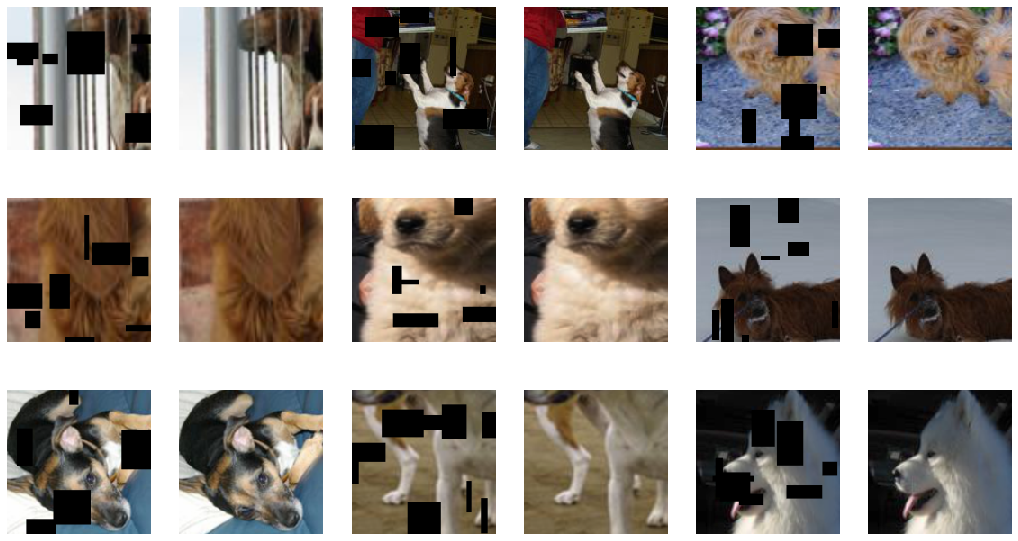

In [6]:
databunch.show_batch(max_n=9)

In [7]:
loss = MSELoss()
learn = unet_learner(databunch, resnet34, pretrained=False, config=unet_config(), loss_func=loss)

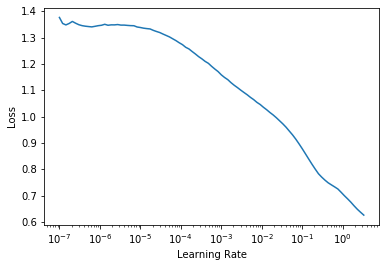

In [8]:
learn.lr_find()

This graph might be a little misleading. I suspect many of the early epochs are spent just learning to copy input pixels to output pixels.

epoch,train_loss,valid_loss,time
0,0.124150,0.112048,01:52
1,0.006392,0.008753,01:30
2,0.005727,0.003979,01:26
3,0.004586,0.003416,01:26
4,0.004932,0.005026,01:26
5,0.004933,0.003296,01:26
6,0.004333,0.002833,01:26
7,0.004342,0.003657,01:27
8,0.004554,0.003074,01:30
9,0.004252,0.002717,01:34


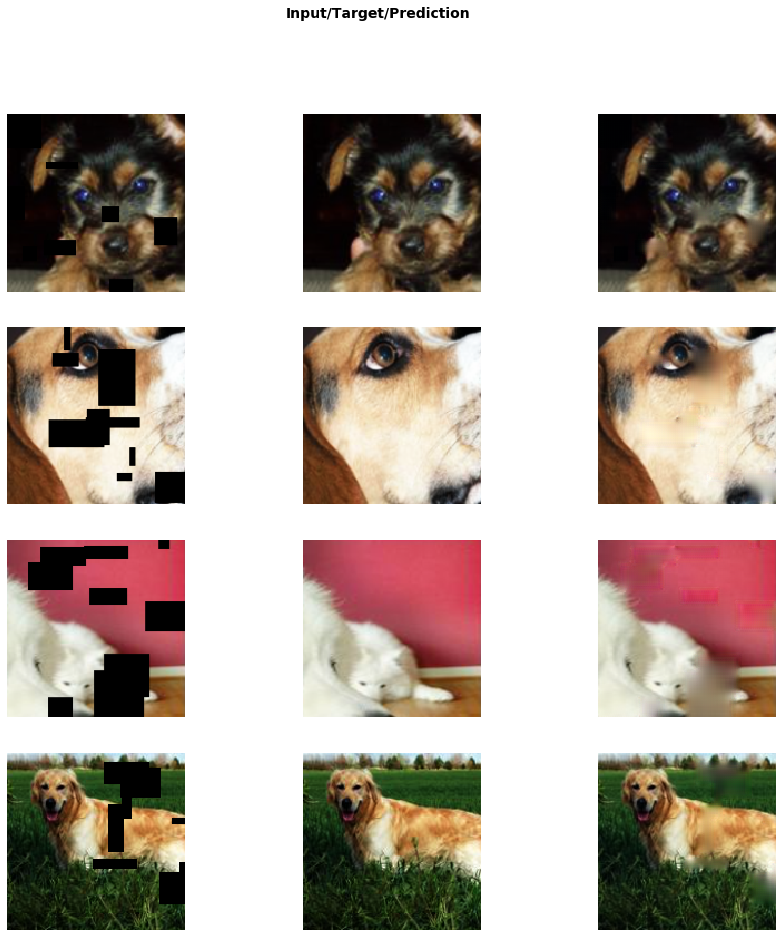

In [9]:
learn.fit_one_cycle(15, 1e-2)
learn.predict(databunch.train_ds.items[0]);
learn.show_results(max_n=4, figsize=(15,15))

In [11]:
# I'm not using fastai2's .export() because I only want to save 
# the model's parameters. 
torch.save(learn.model[0].state_dict(), 'pascal_15_epoch.pth')

Note: This approach seems to work reasonably well, but the outputs are noticably blurry. 

This [paper](https://arxiv.org/pdf/1604.07379.pdf) notes that and instead uses a combined L2 loss + adversarial loss to generate more realistic images. That said, I'm not sure if more realistic images necessarily translates into better downstream performance. For that reason, I'm not quite sure if I'd like to go down the GAN route just yet.